# Effects of taVNS on HRV 
## Discription
2 groups (true label temporally unknown, each patient received VNS for several days during which there were 2 sessions of stimulation). Subject ID from 2020004 to 2020015.

**Warning**: Both the number of days and the number of sessions depend on the subject.
## Objective
- To see the Effects of taVNS on HRV
- Unsupervised clustering to see whether we can distinguise the two groups.

## Input
- nn_interval file (.pickle) for each subject
- info csv (stimulation_timestamped.csv) indicating when the stimulation begins 
**Warning**: the info file was automatically generated. It needs a second check.

## Output
- For each group (patient), we explore the effect of VNS on HRV (boxplot, pre/during/post-stim)
- Taking day as a variable, then we have two independent variable: day and session
- clustering including Features engineering (e.g. $HRV_{during} - \frac{HRV_{pre} + HRV_{post}}{2})$ per patient) and unsupervised learning (e.g. kmeans, DBSCAN)

## Workflow
### 1. double check df_info
- the length of the stimulation should be 20 min
- there should be two stimulations per patient in a single day
### 2. exctract pre/during/post nn_interval and hrv

## Notes:
mising data of 2020006!

## data loading

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import datetime

data_dir = os.path.expanduser("~/Desktop/GT/ECG_VNS/data")
# os.path.exists(data_dir)  # test

info_filename = os.path.join(data_dir, 'stimulation_timestamped.csv')
df_info = pd.read_csv(info_filename, index_col=0)

## filter bad rows in df_info (drop rows)
### Untackled problem:
- in this version, data were discarded if multipul plausible stimulation onsets were found
### improvement 2 implement:
- loops for list creation and concatenation

In [2]:
# raw by raw scanning
# criteria: 20 min duration
# timestamp format: 2/22/21 20:18
tolerence = 100 # 100 seconds
VNS_duration = 1200 # 1200 seconds

list_subj2filtered_df = []
list_date2filtered_df = []
list_time_s2filtered_df = []
list_switch2filtered_df = []  # 1 stands for on, 0 stands for off

array_subjs = df_info['subject'].unique()
for subj in array_subjs:
    df_per_subj = df_info[df_info['subject'] == subj]
    list_date = []
    list_time_s = []
    for index, row in df_per_subj.iterrows():
        # month/day/year
#         date = row['timestamp'].split('/')[0] + '/' + row['timestamp'].split('/')[1] + row['timestamp'].split('/')[2]
        date = row['timestamp'].split(' ')[0] 
        time = row['timestamp'].split('/')[2].split(' ')[1]
        hour = int(time.split(':')[0])
        minute = int(time.split(':')[1])
        time_s = datetime.timedelta(hours=hour, minutes=minute).total_seconds()
        list_date.append(date)
        list_time_s.append(time_s)
    list_time_s = np.array(list_time_s)
    list_date = np.array(list_date)
    _, unique_indices = np.unique(list_time_s, return_index=True)
    unique_indices = np.sort(unique_indices)
    # make sure that there are either 2 or 4 stim each day
    list_time_s = list_time_s[unique_indices]
    list_date = list_date[unique_indices]
    
    list_time_s_updated = []
    list_date_updated = []
    for date in np.unique(list_date):
        indices2search = np.where(list_date == date)[0]
        find_stim_onset = False
        num_stim_found = 0
        for i in indices2search:
            for j in indices2search[np.where(indices2search == i)[0][0] + 1:]:
                if (VNS_duration - tolerence) < (list_time_s[j] - list_time_s[i]) < (VNS_duration + tolerence):
                    list_time_s_updated.append(list_time_s[i])
                    list_time_s_updated.append(list_time_s[j])
                    find_stim_onset = True
                    num_stim_found +=1
        
                        
        if num_stim_found > 2:  # more than two stim onsets were found
#             list_date_updated = list_date_updated[list_date_updated != date]
            list_time_s_updated = list_time_s_updated[:-2 * num_stim_found]
        else:
            for i in range(num_stim_found):
                list_date_updated.append(date)
    list_subj2filtered_df = list_subj2filtered_df + [subj] * len(list_time_s_updated)
    list_date2filtered_df = list_date2filtered_df + [date for date in list_date_updated for _ in (0, 1)]
    list_time_s2filtered_df = list_time_s2filtered_df + list_time_s_updated
    list_switch2filtered_df = list_switch2filtered_df + [i for j in range(len(list_date_updated)) for i in [1, 0] ]

# we create new df from arrays here
df_info_filtered = pd.DataFrame(data=np.array([np.array(list_subj2filtered_df), np.array(list_date2filtered_df),
                                               np.array(list_time_s2filtered_df), 
                                      np.array(list_switch2filtered_df)]).T,
                                    columns=['subj', 'date', 'time_s', 'switch'])
df_info_filtered.to_csv(os.path.join(data_dir, 'stimulation_timestamped_filtered.csv'))
# Test properties here via assert. This applies when 

In [3]:
# Let's see how it looks like
# load the csv if necessary
df_info_filtered.head(12)

,subj,date,time_s,switch
0,2020004,2/22/21,73080.0,1
1,2020004,2/22/21,74340.0,0
2,2020004,2/23/21,75780.0,1
3,2020004,2/23/21,77040.0,0
4,2020004,2/24/21,27300.0,1
5,2020004,2/24/21,28560.0,0
6,2020004,2/24/21,71700.0,1
7,2020004,2/24/21,72960.0,0
8,2020004,2/25/21,31800.0,1
9,2020004,2/25/21,33060.0,0


## extract pre/during/post-stm from pickle files
Output format:

| subj  | date | time |    session      | nn_interval|
| ----- | ---- | ---- | --------------- | ---------- |
|2020014| 2/23 |am/pm | pre/during/post |    value   |

**Be careful, this might take 8h on mac**

In [81]:
noon_s = 12*60*60
def am_or_pm(time_s):
    if 0 < time_s < noon_s:
        output = 'am'
    else:
        output = 'pm'
    return output

def datetime2time_s(datetime_series):
    '''
    datetime is a pd series, no vectorized operation is possible
    '''
    time_s = []
    for i in datetime_series:
        hours = i.hour
        minutes = i.minute
        seconds = i.second
        time_s.append(datetime.timedelta(hours=hours, minutes=minutes, 
                                seconds=seconds).total_seconds())
    return time_s

subj2df = []
date2df = []
time2df = []
session2df = []
nn_interval2df = []
for subj_id in array_subjs:
    nn_filename = os.path.join(data_dir, str(subj_id) + '.pickle')
    df = pd.read_pickle(nn_filename)
#     # truncate to speed up
#     df = df.truncate(before=175000, after= 176000)
#     # reindex by time_s
#     df['time_s_idx'] = datetime2time_s(df['timestamp'])
#     df.set_index('time_s_idx')
    df_info_per_subj = df_info_filtered[df_info_filtered['subj'] == str(subj_id)]
    dates = pd.unique(df_info_per_subj['date'])
    df_info_per_subj_day = df_info_per_subj[df_info_per_subj['date'] == date]
    
    for index, row in df.iterrows():
        # date conversion
        date = row['timestamp'].strftime('%-m/%d/%y')
        time_s = datetime.timedelta(hours=row['timestamp'].hour, minutes=row['timestamp'].minute, 
                            seconds = row['timestamp'].second).total_seconds()
        
        df_info_per_subj_day = df_info_per_subj[df_info_per_subj['date'] == date]
        onset_pre_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '1'].reset_index()['time_s'].astype(float)\
        - VNS_duration
        offset_pre_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '1'].reset_index()['time_s'].astype(float)

        onset_post_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '0'].reset_index()['time_s'].astype(float)
        offset_post_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '0'].reset_index()['time_s'].astype(float)\
        + VNS_duration
        time = am_or_pm(time_s)
        
        for i in range(int(df_info_per_subj_day.shape[0]/2)):  # we have one stim in the morning, one in the afternoon
            if onset_pre_VNS[i] < time_s < offset_pre_VNS[i]:
                date2df.append(date)
                session2df.append('pre')
                time2df.append(time)
                nn_interval2df.append(row['nn_interval'])
                subj2df.append(subj_id)
            elif offset_pre_VNS[i] < time_s < onset_post_VNS[i]:
                date2df.append(date)
                session2df.append('during')
                time2df.append(time)
                nn_interval2df.append(row['nn_interval'])
                subj2df.append(subj_id)
            elif onset_post_VNS[i] < time_s < offset_post_VNS[i]:
                date2df.append(date)
                session2df.append('post')
                time2df.append(time)
                nn_interval2df.append(row['nn_interval'])
                subj2df.append(subj_id)
            else:
                continue
df_filtered = pd.DataFrame(data=np.array([np.array(subj2df), np.array(date2df),np.array(time2df), np.array(session2df),
                                          np.array(nn_interval2df)]).T,
                                    columns=['subj', 'date', 'time', 'session', 'nn_interval'])
df_filtered.to_csv(os.path.join(data_dir, 'nn_interval_whole.csv'))                

## feature extraction from nn_interval 
The output would have a set of features per patient per date per time per session

- mean_nni: The mean of RR-intervals.
- sdnn : The standard deviation of the time interval between successive normal heart beats (i.e. the RR-intervals).
- sdsd: The standard deviation of differences between adjacent RR-intervals
- rmssd: The square root of the mean of the sum of the squares of differences between adjacent NN-intervals. Reflects high frequency (fast or parasympathetic) influences on hrV (i.e., those influencing larger changes from one beat to the next).
- median_nni: Median Absolute values of the successive differences between the RR-intervals.
- nni_50: Number of interval differences of successive RR-intervals greater than 50 ms.
- pnni_50: The proportion derived by dividing nni_50 (The number of interval differences of successive RR-intervals greater than 50 ms) by the total number of RR-intervals.
- nni_20: Number of interval differences of successive RR-intervals greater than 20 ms.
- pnni_20: The proportion derived by dividing nni_20 (The number of interval differences of successive RR-intervals greater than 20 ms) by the total number of RR-intervals.
- range_nni: difference between the maximum and minimum nn_interval.
- cvsd: Coefficient of variation of successive differences equal to the rmssd divided by mean_nni.
- cvnni: Coefficient of variation equal to the ratio of sdnn divided by mean_nni.
- mean_hr: The mean Heart Rate.
- max_hr: Max heart rate.
- min_hr: Min heart rate.
- std_hr: Standard deviation of heart rate.

In [152]:
# load df_filtered if you start from this cell
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_geometrical_features
from hrvanalysis import get_frequency_domain_features
data2df_hrv = []
for subj in pd.unique(df_filtered['subj']):
    df_filtered_temp = df_filtered[df_filtered['subj']==subj]  # temporary df to retrieve stim dates for a subject  
    for date in pd.unique(df_filtered_temp['date']):
        df_filtered_temp = df_filtered[(df_filtered['subj']==subj) & (df_filtered['date']==date)]        
        for time in pd.unique(df_filtered_temp['time']):
            df_filtered_temp = df_filtered[(df_filtered['subj']==subj) & (df_filtered['date']==date) &\
            (df_filtered['time']==time)]
            for session in pd.unique(df_filtered_temp['session']):
                data2calculate_hrv = df_filtered[(df_filtered['subj']==subj) & (df_filtered['date']==date) &\
                                                 (df_filtered['time']==time) & (df_filtered['session']==session)]
                time_domain_features = get_time_domain_features(data2calculate_hrv['nn_interval'].astype(float))
                frequency_domain_features = get_frequency_domain_features(data2calculate_hrv['nn_interval'].astype(float))
                data2df_hrv.append([subj, date, time, session] + list(time_domain_features.values()) +\
                                   list(frequency_domain_features.values()))

df_hrv = pd.DataFrame(data2df_hrv, columns=['subj', 'date', 'time', 'session'] + list(time_domain_features.keys()) +
                      list(frequency_domain_features.keys()))
df_hrv.to_csv(os.path.join(data_dir, 'hrv_features.csv'))

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 241, using nperseg = 241
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 99, using nperseg = 99
  warnings.warn('nperseg = {0:d} is greater than input length '


In [160]:
# a glimpse of df_hrv
print(df_hrv.columns)
df_hrv.head()

Index(['subj', 'date', 'time', 'session', 'mean_nni', 'sdnn', 'sdsd', 'nni_50',
       'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni',
       'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf',
       'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf'],
      dtype='object')


,subj,date,time,session,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
0,2020004,2/22/21,pm,pre,789.000996,167.557260,120.383358,943,62.657807,1189,...,197.368421,46.296296,20.272745,11924.646500,6413.144781,1.859407,65.027714,34.972286,21759.491356,3421.700075
1,2020004,2/22/21,pm,during,737.067052,150.376417,111.370384,1048,60.613071,1347,...,198.675497,43.541364,21.000451,7225.438826,5839.264420,1.237389,55.305036,44.694964,15088.263391,2023.560145
2,2020004,2/22/21,pm,post,756.520625,170.644339,128.062885,1001,62.601626,1277,...,194.805195,41.039672,21.957764,11085.624029,7277.078798,1.523362,60.370329,39.629671,21938.746889,3576.044063
3,2020004,2/23/21,pm,pre,578.139241,81.546339,68.332912,191,48.477157,274,...,197.368421,83.798883,18.717590,1289.116812,1985.488719,0.649269,39.367087,60.632913,4179.199720,904.594189
4,2020004,2/23/21,pm,during,567.039251,78.103561,65.691908,1038,46.318608,1544,...,197.368421,46.153846,17.043396,1732.387759,1864.828001,0.928980,48.159128,51.840872,4202.458487,605.242728


## statistic analysis and visualization
According to preliminay results from SPSS, hrv is heteogeneous.

- paired-sample t test for each patient. Significant results are: nni_20: Number of interval differences of successive RR-intervals greater than 20 ms

In [165]:
import pingouin as pg
for hrv_metric in df_hrv.columns[4:]:
    aov = pg.rm_anova(data=df_hrv, dv=hrv_metric, within='session', subject='subj')
    print(hrv_metric)
    pg.print_table(aov)

mean_nni

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  1.904    0.178  0.175  0.677

sdnn

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  0.116    0.891  0.013  0.713

sdsd

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  0.155    0.857  0.017  0.669

nni_50

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  2.626    0.100  0.226  0.696

pnni_50

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  0.303    0.742  0.033  0.797

nni_20

ANOVA SUMMARY

Sou

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d




ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  0.280    0.759  0.030  0.687

cvnni

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  0.330    0.723  0.035  0.771

mean_hr

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    p-GG-corr    np2    eps  sphericity      W-spher    p-spher
--------  -------  -------  -----  -------  -----------  -----  -----  ------------  ---------  ---------
session         2       18  1.052    0.370        0.345  0.105  0.622  False             0.393      0.024

max_hr

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
session         2       18  2.145    0.146  0.192  0.665

min_hr

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps

<AxesSubplot:xlabel='session', ylabel='nni_20'>

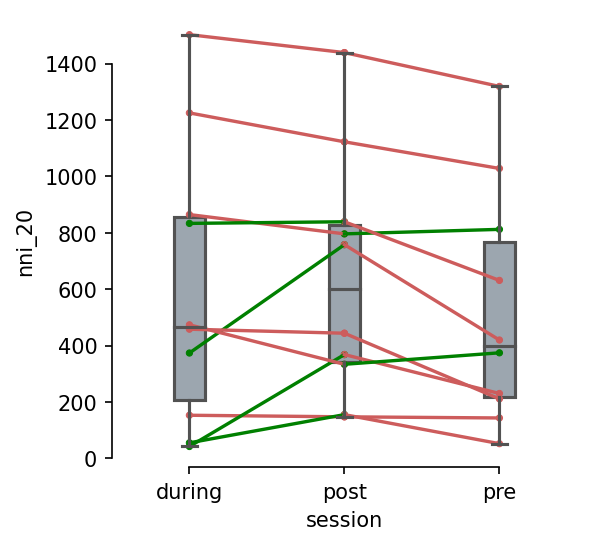

In [166]:
pg.plot_paired(data=df_hrv, dv='nni_20', within='session', subject='subj', dpi=150)